In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 6.2MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import cv2
import time
from keras.applications.vgg16 import preprocess_input
pd.set_option('display.max_colwidth', 200)

import tarfile
import scipy.io
from collections import defaultdict

import matplotlib.pyplot as plt
# !pip install -q efficientnet

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import activations as Ac
from tensorflow.keras.utils import to_categorical

import tensorflow_addons as tfa

# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
train = pd.read_csv('/content/drive/My Drive/fgvc-aircraft-2013b/data/train.csv')
val = pd.read_csv('/content/drive/My Drive/fgvc-aircraft-2013b/data/val.csv')
test = pd.read_csv('/content/drive/My Drive/fgvc-aircraft-2013b/data/test.csv')
train.head()

,filename,Classes,Labels
0,1025794.jpg,707-320,0
1,1340192.jpg,707-320,0
2,0056978.jpg,707-320,0
3,0698580.jpg,707-320,0
4,0450014.jpg,707-320,0


In [ ]:
tpath = "/content/drive/My Drive/fgvc-aircraft-2013b/data/images"

# Load image paths
train_paths = train.filename.apply(lambda x: os.path.join(tpath, x))
val_paths = val.filename.apply(lambda x: os.path.join(tpath, x))
test_paths = test.filename.apply(lambda x: os.path.join(tpath, x))

# Convert to one-hot-encoding-labels
train_labels = to_categorical(train.Labels) 
val_labels = to_categorical(val.Labels)
test_labels = to_categorical(test.Labels)

In [ ]:
def decode_image(filename, label=None, image_size=(299, 299)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [ ]:
def augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    
    if label is None:
        return image
    else:
        return image, label

In [ ]:
batch_size = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(batch_size)
    .prefetch(AUTO)
)

val_dataset = (tf.data.Dataset
        .from_tensor_slices((val_paths, val_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(batch_size)
)

test_dataset = (tf.data.Dataset
        .from_tensor_slices(test_paths)
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(batch_size)
)

In [ ]:
model = tf.keras.Sequential([
        # Input shape 300x300 image with 3 bytes color
        DenseNet201(weights = 'imagenet', 
                       include_top = False,
                       input_shape = (299, 299, 3)),
    
        GlobalAveragePooling2D(),
        Dense(1024, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(100, activation = 'softmax')
])

# create SGD optimizer
optim = tf.keras.optimizers.SGD()
    
# Loss:    categorical_crossentropy good for multi-classification
# Metrics: Calculates how often predictions equal labels
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
    
model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 9, 9, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1967104   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________

In [ ]:
batch_size = 16
EPOCHS = 40

def check(x, y):
    if x == y:
        return 1
    else:
        return 0
    
print('Training...')

n_steps = train_labels.shape[0] // batch_size
model.fit(
    train_dataset,
    steps_per_epoch = n_steps,
    epochs = EPOCHS,
    validation_data = val_dataset,
    verbose = 1
)

Training...
Epoch 1/40
208/208 [==============================] - 1309s 4s/step - loss: 5.9681 - accuracy: 0.0098 - val_loss: 4.9717 - val_accuracy: 0.0099
Epoch 2/40
208/208 [==============================] - 142s 682ms/step - loss: 5.6359 - accuracy: 0.0122 - val_loss: 4.6411 - val_accuracy: 0.0222
Epoch 3/40
208/208 [==============================] - 145s 696ms/step - loss: 5.2535 - accuracy: 0.0235 - val_loss: 4.8791 - val_accuracy: 0.0264
Epoch 4/40
208/208 [==============================] - 145s 700ms/step - loss: 5.0620 - accuracy: 0.0378 - val_loss: 4.4726 - val_accuracy: 0.0366
Epoch 5/40
208/208 [==============================] - 146s 704ms/step - loss: 4.7229 - accuracy: 0.0570 - val_loss: 8.9396 - val_accuracy: 0.0666
Epoch 6/40
208/208 [==============================] - 146s 701ms/step - loss: 4.3478 - accuracy: 0.0848 - val_loss: 45.0392 - val_accuracy: 0.1140
Epoch 7/40
208/208 [==============================] - 146s 702ms/step - loss: 3.9970 - accuracy: 0.1125 - val_los

In [ ]:
pred = model.predict(test_dataset, verbose=1)
    
test['Prediction'] = pred.argmax(axis=1)
test['Score'] = test.apply(lambda x: check(x['Prediction'], x['Labels']), axis=1)
print('Test accuracy on iterations is ', 100 * test.Score.sum() / test.shape[0])

209/209 [==============================] - 574s 3s/step
Test accuracy on iterations is  72.60726072607261


In [ ]:
from keras.models import load_model
model.save('/content/drive/My Drive/final_aircraft_model.h5')  # creates a HDF5 file 'final_aircraft_model.h5'

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/final_aircraft_model.h5')

In [ ]:
aircraft_map = ['707-320', '727-200', '737-200', '737-300', 
                '737-400', '737-500', '737-600', '737-700', 
                '737-800', '737-900', '747-100', '747-200', 
                '747-300', '747-400', '757-200', '757-300', 
                '767-200', '767-300', '767-400', '777-200', 
                '777-300', 'A300B4', 'A310', 'A318', 'A319', 
                'A320', 'A321', 'A330-200', 'A330-300', 
                'A340-200', 'A340-300', 'A340-500', 'A340-600', 
                'A380', 'ATR-42', 'ATR-72', 'An-12', 
                'BAE 146-200', 'BAE 146-300', 'BAE-125', 'Beechcraft 1900', 
                'Boeing 717', 'C-130', 'C-47', 'CRJ-200', 
                'CRJ-700', 'CRJ-900', 'Cessna 172', 'Cessna 208', 
                'Cessna 525', 'Cessna 560', 'Challenger 600', 'DC-10', 
                'DC-3', 'DC-6', 'DC-8', 'DC-9-30', 
                'DH-82', 'DHC-1', 'DHC-6', 'DHC-8-100', 
                'DHC-8-300', 'DR-400', 'Dornier 328', 'E-170', 
                'E-190', 'E-195', 'EMB-120', 'ERJ 135', 
                'ERJ 145', 'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16A/B', 
                'F/A-18', 'Falcon 2000', 'Falcon 900', 'Fokker 100', 
                'Fokker 50', 'Fokker 70', 'Global Express', 'Gulfstream IV', 
                'Gulfstream V', 'Hawk T1', 'Il-76', 'L-1011', 
                'MD-11', 'MD-80', 'MD-87', 'MD-90', 
                'Metroliner', 'Model B200', 'PA-28', 'SR-20', 
                'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado', 
                'Tu-134', 'Tu-154', 'Yak-42']

In [ ]:
import cv2
import numpy as np
from keras.applications.vgg16 import preprocess_input

def runTests():
  base_path = '/content/drive/My Drive/fgvc-aircraft-2013b/data/images/'
  img_path_list = []
  expected_list = []

  # F/A-16A/B
  demo_img1 = base_path + '1736085.jpg'
  img_path_list.append(demo_img1)
  expected_list.append(72)

  # ERJ 135
  demo_img2 = base_path + '0785251.jpg'
  img_path_list.append(demo_img2)
  expected_list.append(68)

  # 737-800
  demo_img3 = base_path + '0457841.jpg'
  img_path_list.append(demo_img3)
  expected_list.append(8)

  # A310
  demo_img4 = base_path + '1539455.jpg'
  img_path_list.append(demo_img4)
  expected_list.append(22)

  # Eurofighter Typhoon
  demo_img5 = base_path + '0607514.jpg'
  img_path_list.append(demo_img5)
  expected_list.append(71)

  # A300B4
  demo_img6 = base_path + '1161624.jpg'
  img_path_list.append(demo_img6)
  expected_list.append(21)

  # EXTERNAL IMAGE: 767-400
  demo_img7 = base_path + '767-400.jpg'
  img_path_list.append(demo_img7)
  expected_list.append(18)
  
  # EXTERNAL IMAGE: Embraer Legacy 600
  demo_img8 = base_path + 'Embraer_Legacy_600.jpg'
  img_path_list.append(demo_img8)
  expected_list.append(70)

  # EXTERNAL IMAGE: C130
  demo_img9 = base_path + 'c130.jpg'
  img_path_list.append(demo_img9)
  expected_list.append(42)
 
  # EXTERNAL IMAGE: An-12
  demo_img10 = base_path + 'an-12.jpg'
  img_path_list.append(demo_img10)
  expected_list.append(36)
 
  # EXTERNAL IMAGE: Cessna 172
  demo_img11 = base_path + 'cessna_172.jpg'
  img_path_list.append(demo_img11)
  expected_list.append(47)

  for i in range(len(img_path_list)):
    # Decode+reshape image for prediction
    img = decode_image(img_path_list[i])
    img = np.expand_dims(img, axis=0)

    # Predict images
    label_num = np.argmax(model.predict(img))
    if(i in range(6, 11)):
      print('< EXTERNAL IMAGE >')
    print('Prediction: ' + str(label_num) + ', ' + aircraft_map[label_num])

    # Evaluate result
    if(expected_list[i] == label_num):
      print('Predicted correctly!')
    else:
      print('Predicted incorrectly! Expected result: ' + str(expected_list[i]) + ', ' + aircraft_map[expected_list[i]])

    # Plot image for visual
    img_raw =  cv2.imread(img_path_list[i])
    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

Prediction: 72, F-16A/B
Predicted correctly!


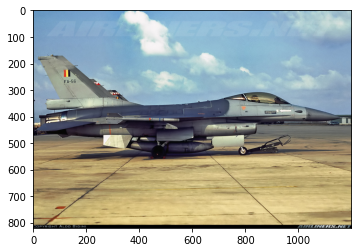

Prediction: 68, ERJ 135
Predicted correctly!


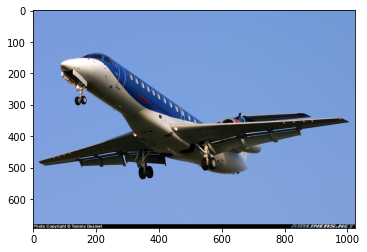

Prediction: 8, 737-800
Predicted correctly!


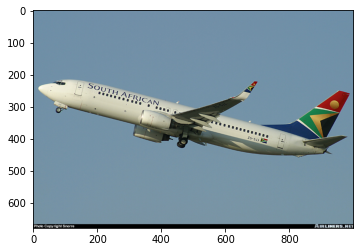

Prediction: 22, A310
Predicted correctly!


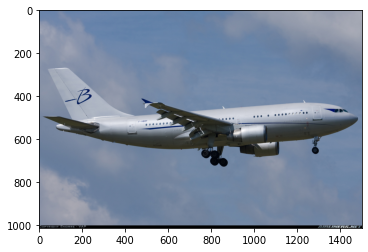

Prediction: 71, Eurofighter Typhoon
Predicted correctly!


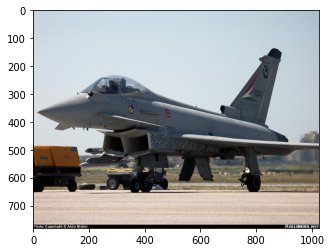

Prediction: 27, A330-200
Predicted incorrectly! Expected result: 21, A300B4


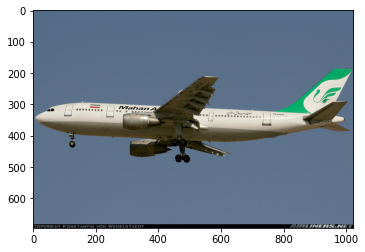

< EXTERNAL IMAGE >
Prediction: 18, 767-400
Predicted correctly!


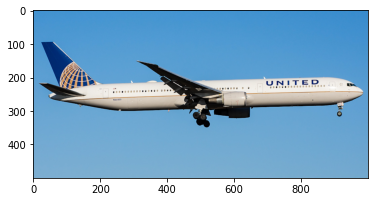

< EXTERNAL IMAGE >
Prediction: 70, Embraer Legacy 600
Predicted correctly!


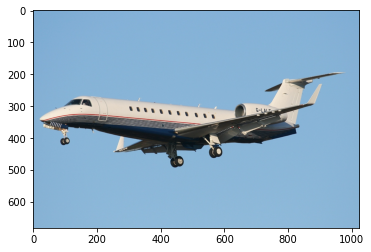

< EXTERNAL IMAGE >
Prediction: 42, C-130
Predicted correctly!


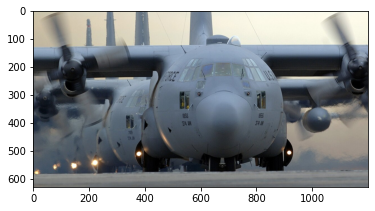

< EXTERNAL IMAGE >
Prediction: 95, Spitfire
Predicted incorrectly! Expected result: 36, An-12


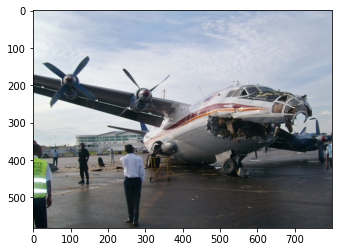

< EXTERNAL IMAGE >
Prediction: 48, Cessna 208
Predicted incorrectly! Expected result: 47, Cessna 172


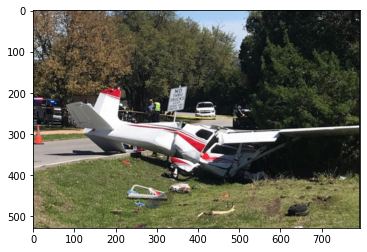

In [ ]:
runTests()